## Notebook Purpose:

We want to create a FAISS index vectorstore to use for similarity search to power our recommendation engine. Our base test case worked well, however, the base embeddings to come out of ViT Transformer are only 384. we're wondering if we can improve performance with increased embeddings. As such, we're using an MLP with NO-NONLINEARITIES and a newer dino model. Below is our process

### Original FAISS Creation:
1. get image embeddings from `'facebookresearch/dino:main', 'dino_vits16'`
    - These embeddings are 384
2. build faiss index and metadata json with these embeddings and image data respectively
3. Test retrievals with random images from the site

### MLP FAISS Creation:
1. Get image features from `DINOV2`
    - this is the last_hidden_state output from the Dino Model and can be considered a 'feature' map
    - These embeddings are 1,257,768
2. Use tunable MLP to change these dimensions to something smaller than the flattened version (~190k) but larger than our original embeddings (384)
3. build faiss index and metadata json with these embeddings and image data respectively
    - the metadata jsons here are the same!
4. test retrievals with the same images

We did a test on the MLP with non-linearities and it performed way worse than expected. This may be because the ReLU shifted values from the features extracted from the DinoV2 model and fundamentally changed the embeddings. We'll test this here. 

If this fails, we'll try once more with a linear FC layer scaling up our 384 to some larger test embedding size as our last try.

In [1]:
import os, time, faiss, json, torch

import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" ##Without this the jupyter kernel will crash. It crashes because of too many OMP instances running, however this prevents that

c:\Users\wolfg\OneDrive\Documents\CivitAI\Project Work\ViTImageRecommender\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## to Do
1. load data, save to faiss
2. save faiss in data (not temp)


In [2]:
img_data_path = '../data/imgs'
df = pd.read_csv('../data/image_index_vit.csv')

## Load model and get output dim
to prepare images for embedding

In [3]:
# Load the pre-trained ViT model
# model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')

c:\Users\wolfg\OneDrive\Documents\CivitAI\Project Work\ViTImageRecommender\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Define Multilayer Perception 
This reduces the output of dinov2 feature extraction for 1,257,768 to something more reasonable

Here we'll construct the class and test it out. 

Why did we do this? 
- the dino we were using before has a set output of 384, this is a little small
- gives us the ability to control our embedding size

In [4]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, output_size, step_size=6, num_layers=3):
        super(MultiLayerPerceptron, self).__init__()
        layers = []
        for i in range(num_layers):
            if i == 0:
                layer_in = input_size
            else:
                layer_in = layer_out
            layer_out = output_size * step_size ** (num_layers - i)
            layers.append(nn.Linear(layer_in, layer_out))
        # Add output layer
        layers.append(nn.Linear(layer_out, output_size))
        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = self.fc(x)
        return x

In [5]:
input_size = 257 * 768  # Input size from your DINOv2 model output
output_size = 512       # Output size
step_size = 5           # Step size for each layer
num_layers = 2          # Number of layers
mlp_3layer_512output = MultiLayerPerceptron(input_size, output_size, step_size, num_layers)
# mlp_4layer_512output = MultiLayerPerceptron(input_size, 512, 6, 3)
# mlp_4layer_128output = MultiLayerPerceptron(input_size, 768, 5, 3)
# mlp_4layer_1028output = MultiLayerPerceptron(input_size, 1028, 5, 3)
# mlp_5layer_128output = MultiLayerPerceptron(input_size, 128, 6, 4)



In [6]:
mlp_3layer_512output

MultiLayerPerceptron(
  (fc): Sequential(
    (0): Linear(in_features=197376, out_features=12800, bias=True)
    (1): Linear(in_features=12800, out_features=2560, bias=True)
    (2): Linear(in_features=2560, out_features=512, bias=True)
  )
)

In [7]:
# #use this cell to experiment with MLP layers
# inputsize = 257*768
# output_size = 512
# step_size = 5
# layers = 2
# for i in range(layers+1):
#     if i == 0:
#         layerin = inputsize
#     else:
#         layerin = layerout 
#     layerout = output_size*step_size**(layers-i)
#     print(f"layer {layers-i} input {layerin}, output {layerout},")

#### Test MLP

In [8]:
# img = Image.open('../data/imgs/10000101.jpg')

In [9]:
# inputs = processor(images=img, return_tensors="pt")
# model = model.to(device)
# outputs = model(**inputs.to(device))
# last_hidden_states = outputs.last_hidden_state
# last_hidden_states.shape

In [10]:
# with torch.no_grad():
#     mlp_3layer_512output = mlp_3layer_512output.to(device)
#     output = mlp_3layer_512output(last_hidden_states.to(device))

# # Output will be a tensor of shape [batch_size, output_size]
# print("Output shape:", output.shape)

## build faiss with MLP Projection
- use mlp functions
- make sure index is set to mlp output

In [11]:
def extract_features(img, processor, model, device = torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    inputs = processor(images=img, return_tensors="pt")
    outputs = model(**inputs.to(device))
    last_hidden_states = outputs.last_hidden_state
    return last_hidden_states

def get_mlp_embeddings(mlp_model, feature_embeddings, device = torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    with torch.no_grad():
        mlp_embeddings = mlp_model(feature_embeddings).to(device)
        return mlp_embeddings

In [12]:
index = faiss.IndexFlatIP(512)
id_index = faiss.IndexIDMap(index)

metadata = {}

In [13]:
id = 0
model = model.to(device)
mlp_3layer_512output = mlp_3layer_512output.to(device)

with torch.no_grad():
  for file_name in os.listdir(img_data_path):
      file_path = os.path.join(img_data_path, file_name)
      try:
          # Open the image file with PIL
          img = Image.open(file_path)
          if img.format in ("JPEG","JPG") and img.mode == "RGB":
            if id % 1000 == 0:
              print("Processed", id, "images")
              
            metadata[id] = {k: v[list(v.keys())[0]] for k,v in df[df['image_id'] == int(file_name.split('.')[0])].to_dict().items() if k not in ['new_url', 'name']}
            pre_embeddings = extract_features(img, processor, model)
            encoded = get_mlp_embeddings(mlp_3layer_512output, pre_embeddings)
            id_index.add_with_ids(encoded.cpu(), np.array(id))
            # break
            id += 1
      except IOError:
          print(f"Error opening file: {file_path}")
          continue

Processed 0 images
Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Processed 6000 images
Processed 7000 images
Processed 8000 images
Processed 9000 images
Processed 10000 images
Processed 11000 images
Processed 12000 images
Processed 13000 images
Processed 14000 images
Processed 15000 images
Processed 16000 images
Processed 17000 images
Processed 18000 images
Processed 19000 images
Processed 20000 images
Processed 21000 images
Processed 22000 images
Processed 23000 images
Processed 24000 images
Processed 25000 images
Processed 26000 images
Processed 27000 images
Processed 28000 images
Processed 29000 images
Processed 30000 images
Processed 31000 images
Processed 32000 images
Processed 33000 images
Processed 34000 images
Processed 35000 images
Processed 36000 images
Processed 37000 images
Processed 38000 images
Processed 39000 images
Processed 40000 images
Processed 41000 images
Processed 42000 images
Processed 43000 images
P

## write Faiss

In [14]:
faiss.write_index(id_index, '../data/image_index_vit_512_embeddings_3layermlp_noRelu_cs.index')

## Reload Index and Metadata for testing

In [15]:
# faiss_index = faiss.read_index('../data/image_index_vit_512_embeddings_3layermlp_cs.index')

# with open('../data/metadata.json', "r") as json_file:
#     metadata = json.load(json_file)


## test faiss

In [16]:
def get_mlp_recommendations_dino(img,
    processor,
    model,
    mlp_model,
    faiss_index,
    k = 30,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ):
  
  feature_embeddings = extract_features(img, processor, model, device)
  encoded_input = get_mlp_embeddings(mlp_model, feature_embeddings, device)
  
  with torch.no_grad():
    
    distances, indices = faiss_index.search(encoded_input.to('cpu'), k)
    
    return distances, indices

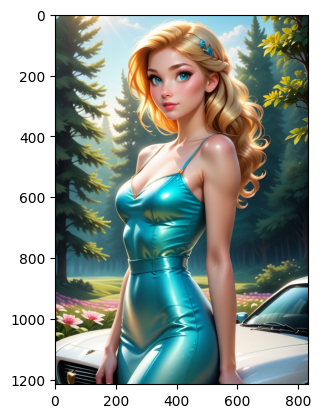

In [17]:
test_img_path = '../data/test_images/bluedressblondewoman.jpeg'
test_img = Image.open(test_img_path)
plt.imshow(test_img)

In [18]:
# Start the timer
start_time = time.time()

# Code to be measured
# ...
distances, indices = get_mlp_recommendations_dino(test_img, processor, model, mlp_3layer_512output, id_index, 30, device)
# End the timer
end_time = time.time()

# Calculate the runtime
runtime = end_time - start_time

# Print the runtime
print(f"Runtime: {runtime} seconds")


Runtime: 1.9322841167449951 seconds


In [24]:
n = 3  # number of columns
m = 2  # number of rows


def plot_image_matrix(n, m, test_img, metadata, indices, temp_dir_path):
    fig0 = plt.figure(figsize=(5, 4))
    plt.imshow(test_img)
    plt.axis('off')
    plt.title('Test Image')
    plt.show()
    
    fig, axes = plt.subplots(m, n, figsize=(10, 8))
    for i in range(m):
        for j in range(n):
            match_img = str(metadata[indices[0][i * n + j]]['image_id']) + '.jpg'
            img = Image.open(os.path.join(temp_dir_path, match_img)).resize((224, 224))
            axes[i, j].imshow(img)
            axes[i, j].set_title("Match " + str(i * n + j))
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

    

In [25]:
# # Load the JSON file
# with open('../data/metadata.json', "r") as json_file:
#     metadata = json.load(json_file)


In [26]:
metadata[indices[0][0]]

{'image_id': 5902582,
 'url': '10a20e48-1b5f-4777-8b7d-b15ab60bbb6d',
 'created_at': '2024-01-26 10:37:28.032',
 'prompt': 'masterpiece,best quality,extreme detail,8k,<lora:lisa:0.8>,lisa2,1girl,solo,breasts,short hair,large breasts,brown hair,gloves,animal ears,tail,choker,cat ears,dark skin,collar,leotard,dark-skinned female,cat tail,brown eyes,',
 'model': 'mfcgDollMix_v20',
 'original_level': 'R',
 'tags': 'adult, person, woman, clothing, costume, swimwear, glove, accessories, jewelry, necklace, whip, face, head, revealing clothes, animal ears, bell, breasts, brown eyes, brown hair, cat ears, cat tail, choker, cleavage, dark-skinned female, dark skin, gloves, highleg, highleg leotard, large breasts, leotard, lips, looking at viewer, neck bell, short hair, solo, tail, thighhighs, female, female swimwear or underwear'}

In [27]:
indices

array([[61431, 37749, 14327, 35024, 55369, 61972, 47917, 92301, 40523,
        29726, 55206, 48173, 87123, 82168, 44035, 65194, 68131, 77259,
        44392, 81409,  9975, 63769, 78454, 50559, 93523, 71117, 43954,
        11744, 25656, 71733]], dtype=int64)

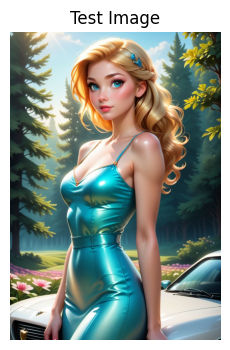

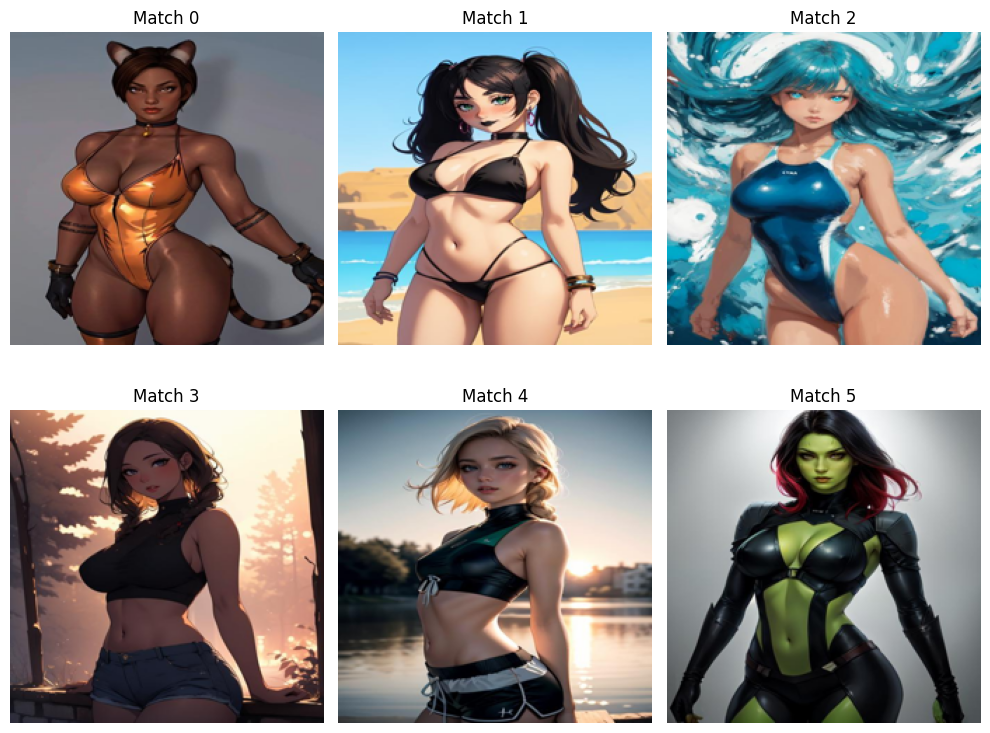

In [28]:
plot_image_matrix(n, m, test_img, metadata, indices, img_data_path)

## Take aways

Currently running